<a href="https://colab.research.google.com/github/jioffe502/cs5787_a1/blob/main/cs5787_a1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab File Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/cs5787

/content/drive/MyDrive/cs5787


Note: as long as you navigate to the directory with the gzip files, this code will run

# Packages and Devices

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import struct
import gzip

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# FashionMNIST

In [ ]:
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

class CustomFashionMNIST(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.root = root
        self.transform = transform
        self.train = train

        if self.train:
            self.data = read_idx(f'{self.root}/train-images-idx3-ubyte.gz')
            self.targets = read_idx(f'{self.root}/train-labels-idx1-ubyte.gz')
        else:
            self.data = read_idx(f'{self.root}/test-images-idx3-ubyte.gz')
            self.targets = read_idx(f'{self.root}/test-labels-idx1-ubyte.gz')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img, mode='L')

        if self.transform is not None:
            img = self.transform(img)

        return img, target



# LeNet5 Model using GELU

In [ ]:
class LeNet5GELU(nn.Module):
    def __init__(self, use_dropout=False, use_batch_norm=False):
        super(LeNet5GELU, self).__init__()
        self.use_dropout = use_dropout
        self.use_batch_norm = use_batch_norm

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        # Batch normalization layers
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm2d(6)
            self.bn2 = nn.BatchNorm2d(16)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First convolutional layer
        x = self.conv1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = nn.functional.gelu(x)
        x = nn.functional.max_pool2d(x, 2)

        # Second convolutional layer
        x = self.conv2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = nn.functional.gelu(x)
        x = nn.functional.max_pool2d(x, 2)

        # Flatten the output
        x = x.view(-1, 16 * 5 * 5)

        # Fully connected layers
        x = nn.functional.gelu(self.fc1(x))
        if self.use_dropout:
            x = self.dropout(x)
        x = nn.functional.gelu(self.fc2(x))
        if self.use_dropout:
            x = self.dropout(x)
        x = self.fc3(x)

        return x



#Data Loading and Preprocessing


In [ ]:
data_path = '/content/drive/MyDrive/cs5787/data'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = CustomFashionMNIST(root=data_path, train=True, transform=transform)
test_dataset = CustomFashionMNIST(root=data_path, train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



# Training and Evaluation Functions

In [ ]:
def train_and_evaluate(model, optimizer, criterion, train_loader, test_loader, num_epochs=25, use_dropout=False):
    model.to(device)

    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate on train set (without dropout)
        model.eval()
        if use_dropout:
            model.dropout.eval()  # Disable dropout for evaluation
        train_accuracy = evaluate_model(model, train_loader)
        train_accuracies.append(train_accuracy)

        # Evaluate on test set
        test_accuracy = evaluate_model(model, test_loader)
        test_accuracies.append(test_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

    return train_accuracies, test_accuracies

def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy



# Training Configurations and Execution


In [ ]:
configs = [
    {"name": "No Regularization (GELU)", "dropout": False, "weight_decay": 0, "batch_norm": False},
    {"name": "Dropout (GELU)", "dropout": True, "weight_decay": 0, "batch_norm": False},
    {"name": "Weight Decay (GELU)", "dropout": False, "weight_decay": 1e-4, "batch_norm": False},
    {"name": "Batch Normalization (GELU)", "dropout": False, "weight_decay": 0, "batch_norm": True}
]

results = {}

for config in configs:
    print(f"\nTraining with {config['name']}:")
    model = LeNet5GELU(use_dropout=config['dropout'], use_batch_norm=config['batch_norm'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=config['weight_decay'])

    train_accuracies, test_accuracies = train_and_evaluate(model, optimizer, criterion, train_loader, test_loader, use_dropout=config['dropout'])

    results[config['name']] = {
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
    }

    # Save model weights
    torch.save(model.state_dict(), f"{config['name']}_weights.pth")

    print(f"Final Test Accuracy with {config['name']}: {test_accuracies[-1]:.4f}")




Training with No Regularization (GELU):
Epoch [1/50], Train Accuracy: 0.8600, Test Accuracy: 0.8498
Epoch [2/50], Train Accuracy: 0.8834, Test Accuracy: 0.8701
Epoch [3/50], Train Accuracy: 0.8992, Test Accuracy: 0.8849
Epoch [4/50], Train Accuracy: 0.9060, Test Accuracy: 0.8882
Epoch [5/50], Train Accuracy: 0.9175, Test Accuracy: 0.8960
Epoch [6/50], Train Accuracy: 0.9213, Test Accuracy: 0.8998
Epoch [7/50], Train Accuracy: 0.9278, Test Accuracy: 0.8993
Epoch [8/50], Train Accuracy: 0.9342, Test Accuracy: 0.9033
Epoch [9/50], Train Accuracy: 0.9409, Test Accuracy: 0.9041
Epoch [10/50], Train Accuracy: 0.9419, Test Accuracy: 0.9010
Epoch [11/50], Train Accuracy: 0.9433, Test Accuracy: 0.8978
Epoch [12/50], Train Accuracy: 0.9506, Test Accuracy: 0.9056
Epoch [13/50], Train Accuracy: 0.9559, Test Accuracy: 0.9013
Epoch [14/50], Train Accuracy: 0.9634, Test Accuracy: 0.9051
Epoch [15/50], Train Accuracy: 0.9626, Test Accuracy: 0.9046
Epoch [16/50], Train Accuracy: 0.9687, Test Accuracy:

# Plotting Convergence Graphs

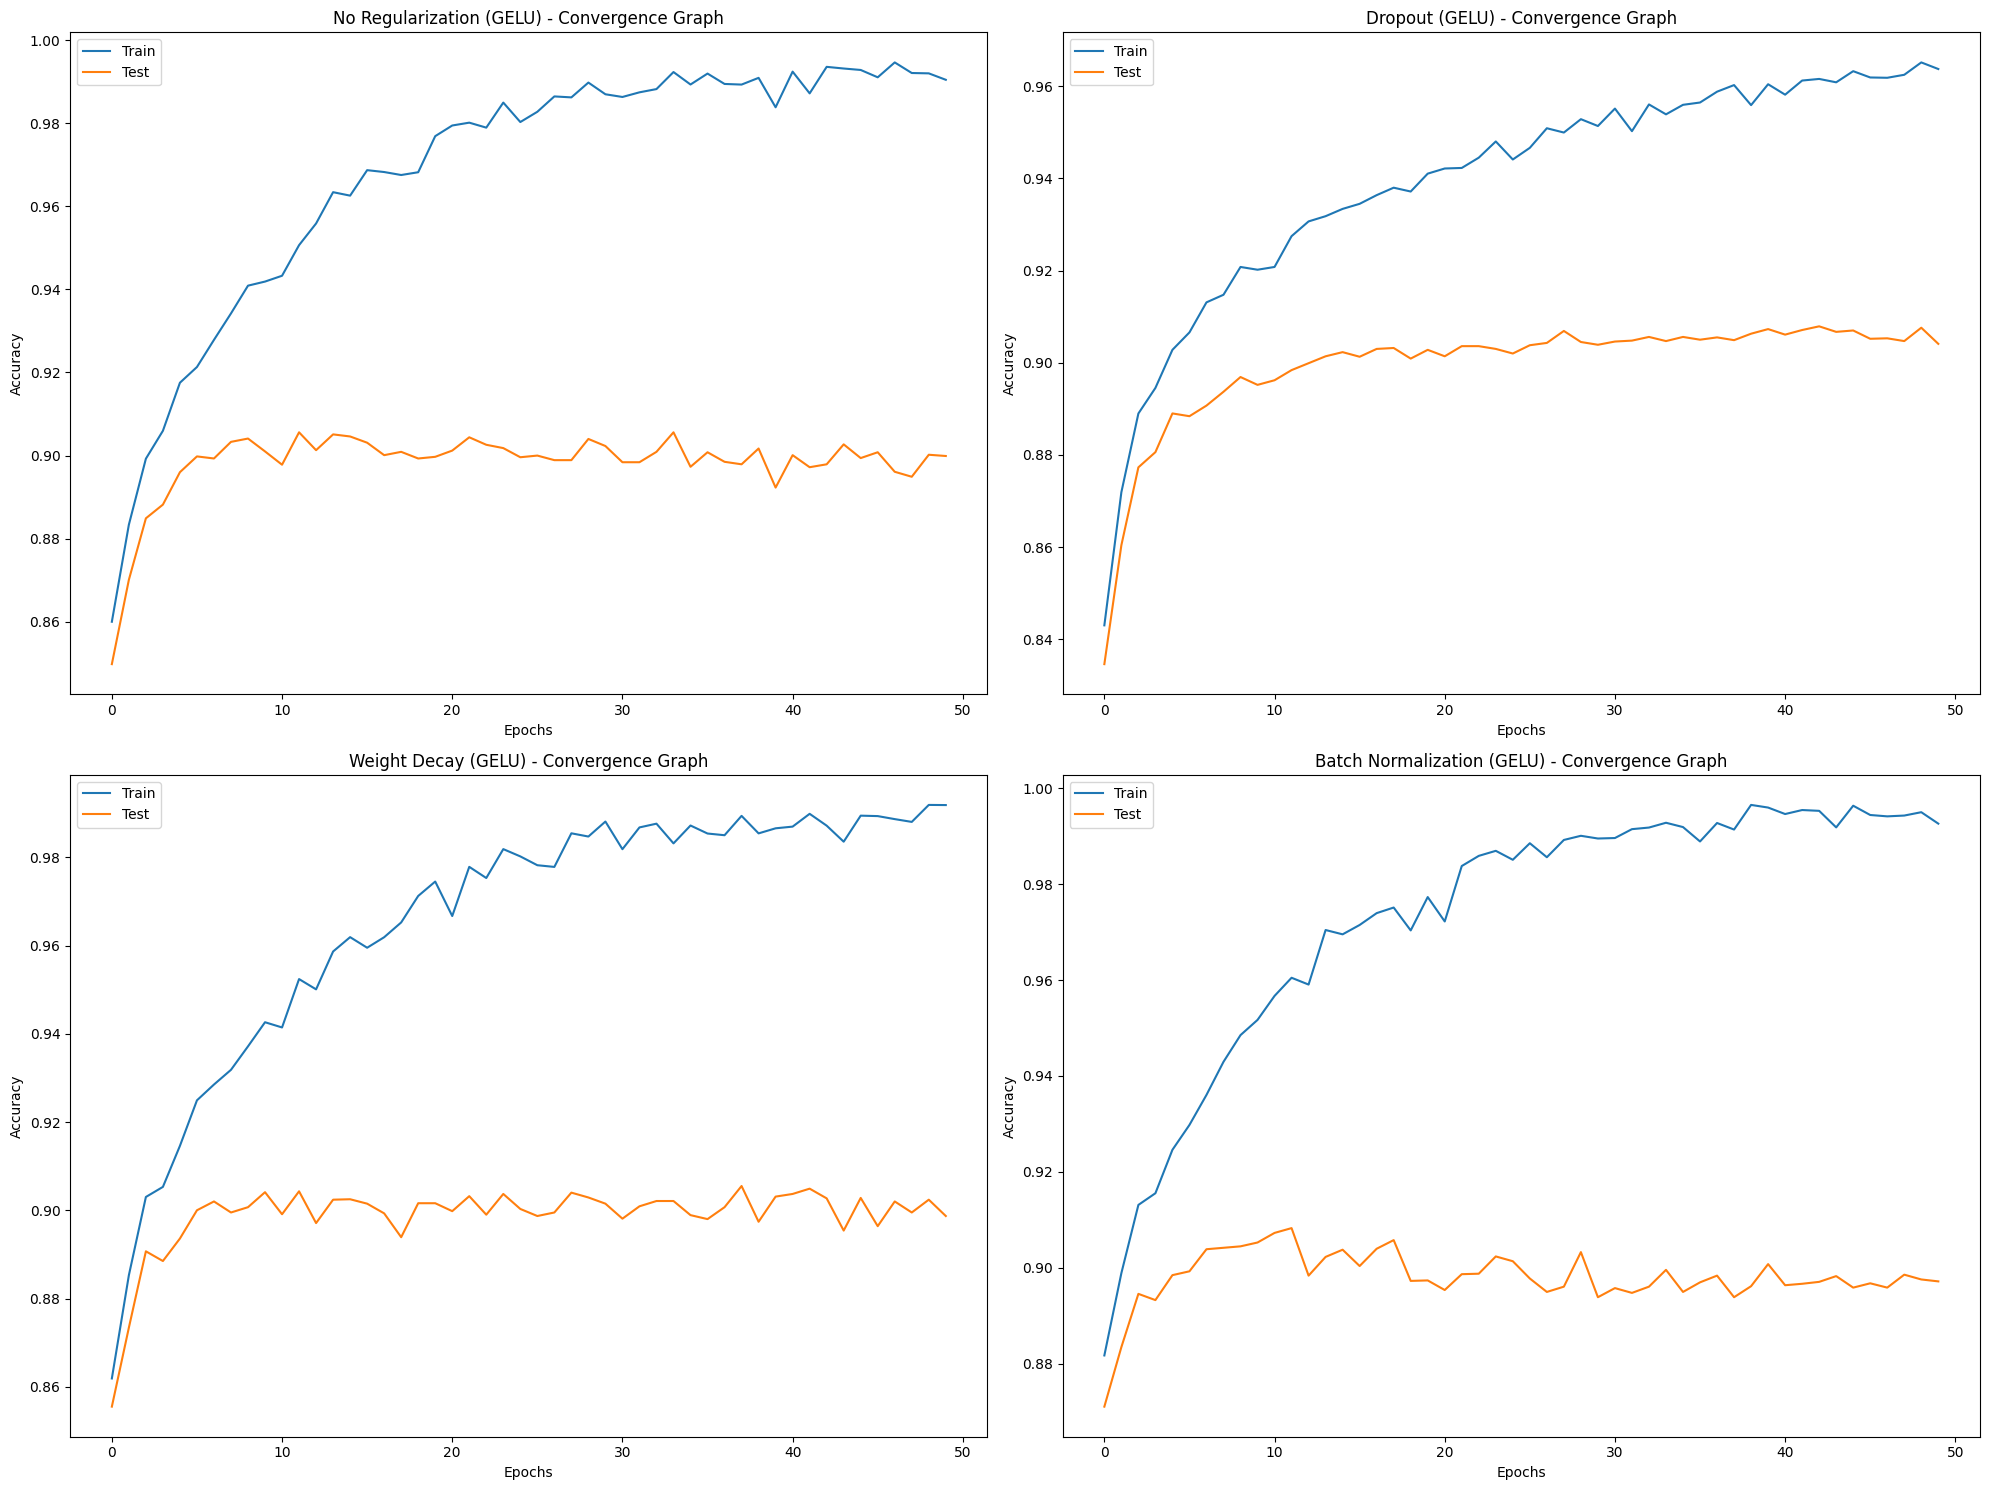

In [ ]:
plt.figure(figsize=(20, 15))
for i, (name, data) in enumerate(results.items(), 1):
    plt.subplot(2, 2, i)
    plt.plot(data['train_accuracies'], label='Train')
    plt.plot(data['test_accuracies'], label='Test')
    plt.title(f'{name} - Convergence Graph')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.savefig('convergence_graphs.png')
plt.show()



# Summary Table

In [ ]:
summary_data = {
    'Technique': [],
    'Train Accuracy': [],
    'Test Accuracy': []
}

for name, data in results.items():
    summary_data['Technique'].append(name)
    summary_data['Train Accuracy'].append(data['train_accuracies'][-1])
    summary_data['Test Accuracy'].append(data['test_accuracies'][-1])

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
summary_df.to_csv('accuracy_summary.csv', index=False)

                 Technique  Train Accuracy  Test Accuracy
  No Regularization (GELU)        0.990450         0.8999
            Dropout (GELU)        0.963733         0.9041
       Weight Decay (GELU)        0.991833         0.8987
Batch Normalization (GELU)        0.992583         0.8972
